# Generating single qubit clustered state with the quantum diffusion model

_Main_ libraries to install: ```torch```, ```tensorcircuit```, ```opt_einsum```, ```QuTip```, ```tqdm```, ```torch```

In [1]:
# import libraries

import torch
import ot
import tensorcircuit as tc
import numpy as np
import scipy as sp
from scipy.stats import unitary_group
import torch
import torch.nn as nn
from torch.linalg import matrix_power
from opt_einsum import contract
from functools import partial
from itertools import combinations
import time
import matplotlib.pyplot as plt
from matplotlib import rc
from tqdm import tqdm
from qutip import *

# settings
rc('text', usetex=True)
rc('axes', linewidth=3)
plt.rcParams.update({'font.size': 22})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['axes.linewidth'] = 1.5
K = tc.set_backend('pytorch')
tc.set_dtype('complex64')

Please first ``pip install -U qiskit`` to enable related functionality in translation module
Please first ``pip install -U cirq`` to enable related functionality in translation module


('complex64', 'float32')

# Plotting on the Bloch (Poincare) sphere

In [2]:
def bloch_xyz(inputs):
    # obtain bloch sphere representation vector
    rho = contract('mi,mj->mij', inputs, inputs.conj())
    sigmas = [sigmax().full(), sigmay().full(), sigmaz().full()]
    pos = [np.real(contract('mii->m', contract('mij,jk->mik', rho, x))) for x in sigmas]
    return pos

# The (forward) Diffusion Class

In [3]:
class DiffusionModel(nn.Module):
    def __init__(self, n, T, Ndata):
        '''
        the diffusion quantum circuit model to scramble arbitrary set of states to Haar random states
        Args:
        n: number of qubits
        T: number of diffusion steps
        Ndata: number of samples in the dataset
        '''
        super().__init__()
        self.n = n
        self.T = T
        self.Ndata = Ndata
    
    def HaarSampleGeneration(self, Ndata, seed):
        '''
        generate random haar states,
        used as inputs in the t=T step for backward denoise
        Args:
        Ndata: number of samples in dataset
        '''
        np.random.seed(seed)
        states_T = unitary_group.rvs(dim=2**self.n, size=Ndata)[:,:,0]
        return torch.from_numpy(states_T).cfloat()
    
    def scrambleCircuit_t(self, t, input, phis, gs=None):
        '''
        obtain the state through diffusion step t
        Args:
        t: diffusion step
        input: the input quantum state
        phis: the single-qubit rotation angles in diffusion circuit
        gs: the angle of RZZ gates in diffusion circuit when n>=2
        '''
        c = tc.Circuit(self.n, inputs=input)
        for tt in range(t):
            # single qubit rotations
            for i in range(self.n):
                c.rz(i, theta=phis[3*self.n*tt+i])
                c.ry(i, theta=phis[3*self.n*tt+self.n+i])
                c.rz(i, theta=phis[3*self.n*tt+2*self.n+i])
            # homogenous RZZ on every pair of qubits (n>=2)
            if self.n >= 2:
                for i, j in combinations(range(self.n), 2):
                    c.rzz(i, j, theta=gs[tt]/(2*np.sqrt(self.n)))
        return c.state()
    
    def set_diffusionData_t(self, t, inputs, diff_hs, seed):
        '''
        obtain the quantum data set through diffusion step t
        Args:
        t: diffusion step
        inputs: the input quantum data set
        diff_hs: the hyper-parameter to control the amplitude of quantum circuit angles
        '''
        # set single-qubit rotation angles
        np.random.seed(seed)
        phis = torch.rand(self.Ndata, 3*self.n*t)*np.pi/4. - np.pi/8.
        phis = phis*(diff_hs.repeat(3*self.n))
        if self.n > 1:
            # set homogenous RZZ gate angles
            gs = torch.rand(self.Ndata, t)*0.2 + 0.4
            gs *= diff_hs
        states = torch.zeros((self.Ndata, 2**self.n)).cfloat()
        for i in range(self.Ndata):
            if self.n > 1:
                states[i] = self.scrambleCircuit_t(t, inputs[i], phis[i], gs[i])
            else:
                states[i] = self.scrambleCircuit_t(t, inputs[i], phis[i])
        return states


# One time-step of the PQC in the denoising process (before measurement, parameter dependent)

In [4]:
def backCircuit(input, params, n_tot, L):
    '''
    the backward denoise parameteric quantum circuits,
    designed following the hardware-efficient ansatz
    output is the state before measurmeents on ancillas
    Args:
    input: input quantum state of n_tot qubits
    params: the parameters of the circuit
    n_tot: number of qubits in the circuits
    L: layers of circuit
    '''
    c = tc.Circuit(n_tot, inputs=input)
    for l in range(L):
        for i in range(n_tot):
            c.rx(i, theta=params[2*n_tot*l+i])
            c.ry(i, theta=params[2*n_tot*l+n_tot+i])
        for i in range(n_tot//2):
            c.cz(2*i, 2*i+1)
        for i in range((n_tot-1)//2):
            c.cz(2*i+1, 2*i+2)
    return c.state()


# The reverse QDDPM class

In [5]:
class QDDPM(nn.Module):
    def __init__(self, n, na, T, L):
        '''
        the QDDPM model: backward process only work on cpu
        Args:
        n: number of data qubits
        na: number of ancilla qubits
        T: number of diffusion steps
        L: layers of circuit in each backward step
        '''
        super().__init__()
        self.n = n
        self.na = na
        self.n_tot = n + na
        self.T = T
        self.L = L
        # embed the circuit to a vectorized pytorch neural network layer
        self.backCircuit_vmap = K.vmap(partial(backCircuit, n_tot=self.n_tot, L=L), vectorized_argnums=0)

    def set_diffusionSet(self, states_diff):
        self.states_diff = torch.from_numpy(states_diff).cfloat()

    def randomMeasure(self, inputs):
        '''
        Given the inputs on both data & ancilla qubits before measurmenets,
        calculate the post-measurement state.
        The measurement and state output are calculated in parallel for data samples
        Args:
        inputs: states to be measured, first na qubit is ancilla
        '''
        m_probs = (torch.abs(inputs.reshape(inputs.shape[0], 2**self.na, 2**self.n))**2).sum(dim=2)
        m_res = torch.multinomial(m_probs, num_samples=1).squeeze() # measurment results
        indices = 2**self.n * m_res.view(-1, 1) + torch.arange(2**self.n)
        post_state = torch.gather(inputs, 1, indices)
        norms = torch.sqrt(torch.sum(torch.abs(post_state)**2, axis=1)).unsqueeze(dim=1)
        return 1./norms * post_state

    def backwardOutput_t(self, inputs, params):
        '''
        Backward denoise process at step t
        Args:
        inputs: the input data set at step t
        '''
        # outputs through quantum circuits before measurement
        output_full = self.backCircuit_vmap(inputs, params) 
        # perform measurement
        output_t = self.randomMeasure(output_full)
        return output_t
    
    def prepareInput_t(self, inputs_T, params_tot, t, Ndata):
        '''
        prepare the input samples for step t
        Args:
        inputs_T: the input state at the beginning of backward
        params_tot: all circuit parameters till step t+1
        '''
        self.input_tplus1 = torch.zeros((Ndata, 2**self.n_tot)).cfloat()
        self.input_tplus1[:,:2**self.n] = inputs_T
        params_tot = torch.from_numpy(params_tot).float()
        with torch.no_grad():
            for tt in range(self.T-1, t, -1):
                self.input_tplus1[:,:2**self.n] = self.backwardOutput_t(self.input_tplus1, params_tot[tt])
        return self.input_tplus1
    
    def backDataGeneration(self, inputs_T, params_tot, Ndata):
        '''
        generate the dataset in backward denoise process with training data set
        '''
        states = torch.zeros((self.T+1, Ndata, 2**self.n_tot)).cfloat()
        states[-1, :, :2**self.n] = inputs_T
        params_tot = torch.from_numpy(params_tot).float()
        with torch.no_grad():
            for tt in range(self.T-1, -1, -1):
                states[tt, :, :2**self.n] = self.backwardOutput_t(states[tt+1], params_tot[tt])
        return states


# Various distance measures

In [6]:
def naturalDistance(Set1, Set2):
    '''
        a natural measure on the distance between two sets of quantum states
        definition: 2*d - r1-r2
        d: mean of inter-distance between Set1 and Set2
        r1/r2: mean of intra-distance within Set1/Set2
    '''
    # a natural measure on the distance between two sets, according to trace distance
    r11 = 1. - torch.mean(torch.abs(contract('mi,ni->mn', Set1.conj(), Set1))**2)
    r22 = 1. - torch.mean(torch.abs(contract('mi,ni->mn', Set2.conj(), Set2))**2)
    r12 = 1. - torch.mean(torch.abs(contract('mi,ni->mn', Set1.conj(), Set2))**2)
    return 2*r12 - r11 - r22


def WassDistance(Set1, Set2):
    '''
        calculate the Wasserstein distance between two sets of quantum states
        the cost matrix is the inter trace distance between sets S1, S2
    '''
    D = 1. - torch.abs(Set1.conj() @ Set2.T)**2.
    emt = torch.empty(0)
    Wass_dis = ot.emd2(emt, emt, M=D)
    return Wass_dis


def sinkhornDistance(Set1, Set2, reg=0.005, log=False):
    '''
        calculate the Sinkhorn distance between two sets of quantum states
        the cost matrix is the inter trace distance between sets S1, S2
        reg: the regularization coefficient
        log: whether to use the log-solver
    '''
    D = 1. - torch.abs(Set1.conj() @  Set2.T)**2.
    emt = torch.empty(0)
    if log == True:
        sh_dis = ot.sinkhorn2(emt, emt, M=D, reg=reg, method='sinkhorn_log')
    else:
        sh_dis = ot.sinkhorn2(emt, emt, M=D, reg=reg)
    return sh_dis


## Generate the clustered data set (clustered around $\ket{0}$)

In [7]:
def cluster0Gen(n, N_train, scale, seed=None):
    '''
    generate random quantum states close to |0...0>
    Args:
    n: number of qubits
    N_train: number of data to generate
    scale: the scaling factor on amplitudes except |0...0>
    seed: control the randomness
    '''
    np.random.seed(seed)
    # amplitude for basis except |0...0>
    remains = np.random.randn(N_train,2**n-1)+1j*np.random.randn(N_train,2**n-1) 
    states = np.hstack((np.ones((N_train,1)), scale*remains)) # un-normalized
    states /= np.tile(np.linalg.norm(states, axis=1).reshape((1, N_train)), (2**n, 1)).T
    return states.astype(np.complex64)

## Fidelity computation

In [8]:
def compute_fidelity(Xout):
    '''
    Given Xout of shape [T+1, Ndata, 2**n], compute the fidelity between times t = t and t = 0 as a function of T averaged over the batch 
    '''
    arr = np.zeros(T)
    for i in range(T):
        arr[i] = np.sum([np.abs(np.inner(np.conjugate(Xout[0][kk][:]),Xout[i][kk][:]))**2 for kk in range(Ndata)]) / Ndata
    return arr


## Generate diffusion dataset

In [9]:
# generate dfifusion data set
n = 1 # single qubit dataset 
T = 20 # number of time-steps in the diffusion and denoising process
Ndata = 100 #number of training data

diff_hs = np.linspace(1., 4., T) # diffusion hyperparameters
diff_hs = torch.from_numpy(diff_hs)

model_diff = DiffusionModel(n, T, Ndata) # define the model

DataSet = cluster0Gen(1, Ndata, 0.08, seed=12) 

X = torch.from_numpy(DataSet)

Xout = np.zeros((T+1, Ndata, 2**n), dtype=np.complex64)
Xout[0] = X.numpy()

for t in tqdm(range(1, T+1)):
    Xout[t] = model_diff.set_diffusionData_t(t, X, diff_hs[:t], seed=t).numpy()


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


100%|███████████████████████████████████████████| 20/20 [00:07<00:00,  2.80it/s]


Text(0.5, 1.0, 'Fidelity across diffusion')

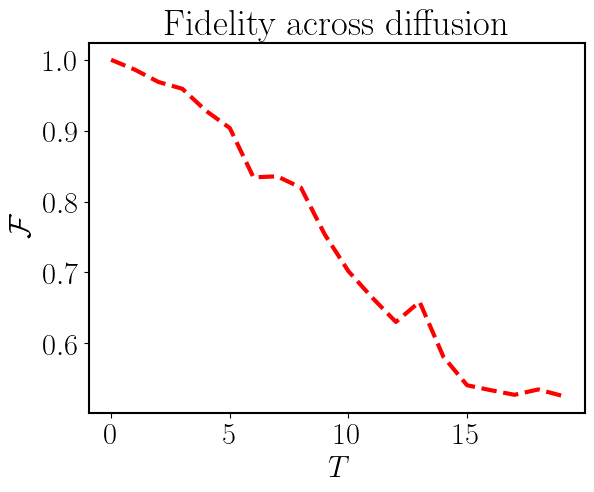

In [10]:
# visualize the decay of the fidelity as the diffusion proceeds

arr = compute_fidelity(Xout)
plt.plot(arr,"--r",linewidth=3)
plt.xlabel(r'$T$')
plt.ylabel(r'$\mathcal{F}$')
plt.title('Fidelity across diffusion')

## visualize the diffusion on the Bloch sphere

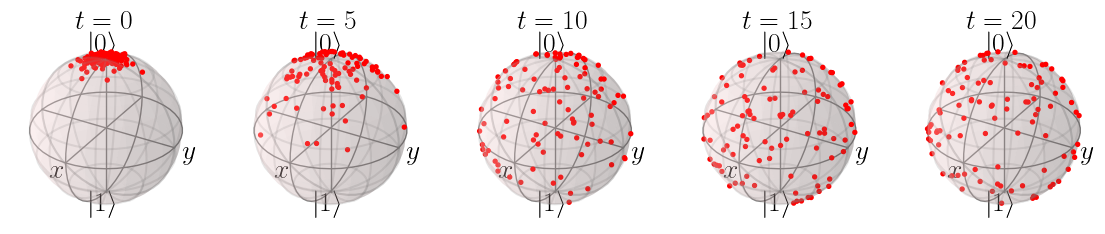

In [11]:
fig, axs = plt.subplots(1,5, figsize=(14,10), subplot_kw={'projection': '3d'})
cc = 0
indices = np.random.choice(Ndata, Ndata, replace=False)
diff_states = Xout[:,indices]
for i in range(0, T+1, 5):
    xs0, ys0, zs0 = bloch_xyz(diff_states[i])
    b0 = Bloch(fig=fig, axes=axs[cc])
    b0.clear()
    b0.add_points([xs0, ys0, zs0])
    b0.point_color = ['r']*Ndata
    b0.point_style = 'm'
    b0.point_size = 8*np.ones(Ndata)
    b0.render()
    axs[cc].set_title(r'$t=%d$'%i, fontsize=20)
    cc += 1


## Main training function for the model

In [12]:
def Training_t(model, t, inputs_T, params_tot, Ndata, epochs):
    '''
    the trianing for the backward PQC at step t
    input_tplus1: the output from step t+1, as the role of input at step t
    Args:
    model: the QDDPM model
    t: the diffusion step
    inputs_T: the input data at step t=T
    params_tot: collection of PQC parameters before step t
    Ndata: number of samples in dataset
    epochs: the number of iterations
    '''
    input_tplus1 = model.prepareInput_t(inputs_T, params_tot, t, Ndata) # prepare input
    states_diff = model.states_diff
    loss_hist = [] # record of training history

    # initialize parameters
    np.random.seed()
    params_t = torch.tensor(np.random.normal(size=2 * model.n_tot * model.L), requires_grad=True)
    # set optimizer and learning rate decay
    optimizer = torch.optim.Adam([params_t], lr=0.0005)
    
    t0 = time.time()
    for step in range(epochs):
        indices = np.random.choice(states_diff.shape[1], size=Ndata, replace=False)
        true_data = states_diff[t, indices]

        output_t = model.backwardOutput_t(input_tplus1, params_t)
        loss = naturalDistance(output_t, true_data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_hist.append(loss) # record the current loss
        
        if step%100 == 0:
            loss_value = loss_hist[-1]
            print("Step %s, loss: %s, time elapsed: %s seconds"%(step, loss_value, time.time() - t0))

    return params_t, torch.stack(loss_hist)

In [13]:
# denoise training

na = 1 # number of ancilla qubits
L = 4 # layer of backward PQC
epochs = 2001 # number of training epochs

# generate random samples at step t=T
diffModel = DiffusionModel(n, T, Ndata)
inputs_T = diffModel.HaarSampleGeneration(Ndata, seed=22)

# load diffusion process
states_diff = Xout
model = QDDPM(n=n, na=na, T=T, L=L)
model.set_diffusionSet(states_diff)
params_tot = np.zeros((T, 2*(n+na)*L))
loss_tot = np.zeros((T,epochs))

for t in tqdm(range(T-1, -1, -1)):
    params, loss_hist = Training_t(model, t, inputs_T, params_tot, Ndata, epochs) #train the PQC at t, store the results in params_tot, and then 
    params_tot[t] = (params).detach().numpy()                                     # train at t - 1, and so on
    loss_tot[t] = (loss_hist).detach().numpy() 

  0%|                                                    | 0/20 [00:00<?, ?it/s]

Step 0, loss: tensor(0.0461, grad_fn=<SubBackward0>), time elapsed: 0.1845698356628418 seconds
Step 100, loss: tensor(0.0304, grad_fn=<SubBackward0>), time elapsed: 0.7745957374572754 seconds
Step 200, loss: tensor(0.0255, grad_fn=<SubBackward0>), time elapsed: 1.3626208305358887 seconds
Step 300, loss: tensor(0.0173, grad_fn=<SubBackward0>), time elapsed: 2.050855875015259 seconds
Step 400, loss: tensor(0.0182, grad_fn=<SubBackward0>), time elapsed: 2.684213876724243 seconds
Step 500, loss: tensor(0.0127, grad_fn=<SubBackward0>), time elapsed: 3.3009259700775146 seconds
Step 600, loss: tensor(0.0168, grad_fn=<SubBackward0>), time elapsed: 3.893817663192749 seconds
Step 700, loss: tensor(0.0127, grad_fn=<SubBackward0>), time elapsed: 4.485945701599121 seconds
Step 800, loss: tensor(0.0042, grad_fn=<SubBackward0>), time elapsed: 5.082510709762573 seconds
Step 900, loss: tensor(0.0033, grad_fn=<SubBackward0>), time elapsed: 5.674259901046753 seconds
Step 1000, loss: tensor(0.0061, grad_f

  5%|██▏                                         | 1/20 [00:12<04:01, 12.73s/it]

Step 2000, loss: tensor(0.0002, grad_fn=<SubBackward0>), time elapsed: 12.532878875732422 seconds
Step 0, loss: tensor(0.0685, grad_fn=<SubBackward0>), time elapsed: 0.006915092468261719 seconds
Step 100, loss: tensor(0.0242, grad_fn=<SubBackward0>), time elapsed: 0.6011948585510254 seconds
Step 200, loss: tensor(0.0124, grad_fn=<SubBackward0>), time elapsed: 1.224733829498291 seconds
Step 300, loss: tensor(0.0065, grad_fn=<SubBackward0>), time elapsed: 1.8295109272003174 seconds
Step 400, loss: tensor(0.0058, grad_fn=<SubBackward0>), time elapsed: 2.4276750087738037 seconds
Step 500, loss: tensor(0.0023, grad_fn=<SubBackward0>), time elapsed: 3.0243828296661377 seconds
Step 600, loss: tensor(0.0032, grad_fn=<SubBackward0>), time elapsed: 3.6174299716949463 seconds
Step 700, loss: tensor(0.0005, grad_fn=<SubBackward0>), time elapsed: 4.20455002784729 seconds
Step 800, loss: tensor(0.0017, grad_fn=<SubBackward0>), time elapsed: 4.8010759353637695 seconds
Step 900, loss: tensor(0.0023, g

 10%|████▍                                       | 2/20 [00:25<03:47, 12.63s/it]

Step 0, loss: tensor(0.0084, grad_fn=<SubBackward0>), time elapsed: 0.006516933441162109 seconds
Step 100, loss: tensor(0.0026, grad_fn=<SubBackward0>), time elapsed: 0.6110889911651611 seconds
Step 200, loss: tensor(0.0035, grad_fn=<SubBackward0>), time elapsed: 1.241837978363037 seconds
Step 300, loss: tensor(0.0002, grad_fn=<SubBackward0>), time elapsed: 1.88328218460083 seconds
Step 400, loss: tensor(0.0004, grad_fn=<SubBackward0>), time elapsed: 2.4819817543029785 seconds
Step 500, loss: tensor(0.0117, grad_fn=<SubBackward0>), time elapsed: 3.0719499588012695 seconds
Step 600, loss: tensor(0.0022, grad_fn=<SubBackward0>), time elapsed: 3.6600799560546875 seconds
Step 700, loss: tensor(0.0013, grad_fn=<SubBackward0>), time elapsed: 4.26530385017395 seconds
Step 800, loss: tensor(0.0017, grad_fn=<SubBackward0>), time elapsed: 4.920694828033447 seconds
Step 900, loss: tensor(0.0013, grad_fn=<SubBackward0>), time elapsed: 5.520953893661499 seconds
Step 1000, loss: tensor(0.0009, grad_

 15%|██████▌                                     | 3/20 [00:37<03:35, 12.66s/it]

Step 0, loss: tensor(0.1474, grad_fn=<SubBackward0>), time elapsed: 0.006585836410522461 seconds
Step 100, loss: tensor(0.0896, grad_fn=<SubBackward0>), time elapsed: 0.6020569801330566 seconds
Step 200, loss: tensor(0.0412, grad_fn=<SubBackward0>), time elapsed: 1.1851279735565186 seconds
Step 300, loss: tensor(0.0169, grad_fn=<SubBackward0>), time elapsed: 1.8022139072418213 seconds
Step 400, loss: tensor(0.0125, grad_fn=<SubBackward0>), time elapsed: 2.4118058681488037 seconds
Step 500, loss: tensor(0.0140, grad_fn=<SubBackward0>), time elapsed: 2.998563051223755 seconds
Step 600, loss: tensor(0.0063, grad_fn=<SubBackward0>), time elapsed: 3.6239869594573975 seconds
Step 700, loss: tensor(0.0037, grad_fn=<SubBackward0>), time elapsed: 4.212656736373901 seconds
Step 800, loss: tensor(0.0004, grad_fn=<SubBackward0>), time elapsed: 4.85114598274231 seconds
Step 900, loss: tensor(0.0092, grad_fn=<SubBackward0>), time elapsed: 5.450578927993774 seconds
Step 1000, loss: tensor(0.0019, gra

 20%|████████▊                                   | 4/20 [00:50<03:23, 12.75s/it]

Step 0, loss: tensor(0.0660, grad_fn=<SubBackward0>), time elapsed: 0.020076990127563477 seconds
Step 100, loss: tensor(0.0686, grad_fn=<SubBackward0>), time elapsed: 0.6358509063720703 seconds
Step 200, loss: tensor(0.0326, grad_fn=<SubBackward0>), time elapsed: 1.225675106048584 seconds
Step 300, loss: tensor(0.0275, grad_fn=<SubBackward0>), time elapsed: 1.8160090446472168 seconds
Step 400, loss: tensor(0.0215, grad_fn=<SubBackward0>), time elapsed: 2.409999132156372 seconds
Step 500, loss: tensor(0.0276, grad_fn=<SubBackward0>), time elapsed: 3.0330970287323 seconds
Step 600, loss: tensor(0.0164, grad_fn=<SubBackward0>), time elapsed: 3.8223989009857178 seconds
Step 700, loss: tensor(0.0097, grad_fn=<SubBackward0>), time elapsed: 4.4118030071258545 seconds
Step 800, loss: tensor(0.0071, grad_fn=<SubBackward0>), time elapsed: 4.990885972976685 seconds
Step 900, loss: tensor(0.0030, grad_fn=<SubBackward0>), time elapsed: 5.5725791454315186 seconds
Step 1000, loss: tensor(0.0020, grad

 25%|███████████                                 | 5/20 [01:03<03:11, 12.75s/it]

Step 0, loss: tensor(0.0757, grad_fn=<SubBackward0>), time elapsed: 0.006855964660644531 seconds
Step 100, loss: tensor(0.0262, grad_fn=<SubBackward0>), time elapsed: 0.6062021255493164 seconds
Step 200, loss: tensor(0.0122, grad_fn=<SubBackward0>), time elapsed: 1.1925561428070068 seconds
Step 300, loss: tensor(0.0085, grad_fn=<SubBackward0>), time elapsed: 1.9626502990722656 seconds
Step 400, loss: tensor(0.0017, grad_fn=<SubBackward0>), time elapsed: 2.534013032913208 seconds
Step 500, loss: tensor(0.0016, grad_fn=<SubBackward0>), time elapsed: 3.097273111343384 seconds
Step 600, loss: tensor(0.0015, grad_fn=<SubBackward0>), time elapsed: 3.669335126876831 seconds
Step 700, loss: tensor(0.0026, grad_fn=<SubBackward0>), time elapsed: 4.273068189620972 seconds
Step 800, loss: tensor(0.0006, grad_fn=<SubBackward0>), time elapsed: 4.8836259841918945 seconds
Step 900, loss: tensor(0.0001, grad_fn=<SubBackward0>), time elapsed: 5.486994981765747 seconds
Step 1000, loss: tensor(0.0028, gra

 30%|█████████████▏                              | 6/20 [01:16<02:58, 12.73s/it]

Step 0, loss: tensor(0.2014, grad_fn=<SubBackward0>), time elapsed: 0.006143093109130859 seconds
Step 100, loss: tensor(0.1422, grad_fn=<SubBackward0>), time elapsed: 0.5876390933990479 seconds
Step 200, loss: tensor(0.1250, grad_fn=<SubBackward0>), time elapsed: 1.1600170135498047 seconds
Step 300, loss: tensor(0.0866, grad_fn=<SubBackward0>), time elapsed: 1.7894742488861084 seconds
Step 400, loss: tensor(0.0638, grad_fn=<SubBackward0>), time elapsed: 2.3670852184295654 seconds
Step 500, loss: tensor(0.0529, grad_fn=<SubBackward0>), time elapsed: 2.9429051876068115 seconds
Step 600, loss: tensor(0.0427, grad_fn=<SubBackward0>), time elapsed: 3.5285489559173584 seconds
Step 700, loss: tensor(0.0317, grad_fn=<SubBackward0>), time elapsed: 4.118743181228638 seconds
Step 800, loss: tensor(0.0207, grad_fn=<SubBackward0>), time elapsed: 4.711554050445557 seconds
Step 900, loss: tensor(0.0228, grad_fn=<SubBackward0>), time elapsed: 5.307663202285767 seconds
Step 1000, loss: tensor(0.0176, g

 35%|███████████████▍                            | 7/20 [01:29<02:45, 12.72s/it]

Step 0, loss: tensor(0.1553, grad_fn=<SubBackward0>), time elapsed: 0.006357908248901367 seconds
Step 100, loss: tensor(0.1278, grad_fn=<SubBackward0>), time elapsed: 0.6206138134002686 seconds
Step 200, loss: tensor(0.0794, grad_fn=<SubBackward0>), time elapsed: 1.235473871231079 seconds
Step 300, loss: tensor(0.0912, grad_fn=<SubBackward0>), time elapsed: 2.00732684135437 seconds
Step 400, loss: tensor(0.0703, grad_fn=<SubBackward0>), time elapsed: 2.657644033432007 seconds
Step 500, loss: tensor(0.0424, grad_fn=<SubBackward0>), time elapsed: 3.2989089488983154 seconds
Step 600, loss: tensor(0.0158, grad_fn=<SubBackward0>), time elapsed: 3.9157228469848633 seconds
Step 700, loss: tensor(0.0110, grad_fn=<SubBackward0>), time elapsed: 4.5631349086761475 seconds
Step 800, loss: tensor(0.0064, grad_fn=<SubBackward0>), time elapsed: 5.42413592338562 seconds
Step 900, loss: tensor(0.0043, grad_fn=<SubBackward0>), time elapsed: 6.335347890853882 seconds
Step 1000, loss: tensor(0.0008, grad_

 40%|█████████████████▌                          | 8/20 [01:43<02:40, 13.36s/it]

Step 0, loss: tensor(0.1310, grad_fn=<SubBackward0>), time elapsed: 0.010522842407226562 seconds
Step 100, loss: tensor(0.1177, grad_fn=<SubBackward0>), time elapsed: 0.7488200664520264 seconds
Step 200, loss: tensor(0.0763, grad_fn=<SubBackward0>), time elapsed: 1.442676067352295 seconds
Step 300, loss: tensor(0.0385, grad_fn=<SubBackward0>), time elapsed: 2.058933973312378 seconds
Step 400, loss: tensor(0.0278, grad_fn=<SubBackward0>), time elapsed: 2.6615209579467773 seconds
Step 500, loss: tensor(0.0138, grad_fn=<SubBackward0>), time elapsed: 3.268928050994873 seconds
Step 600, loss: tensor(0.0176, grad_fn=<SubBackward0>), time elapsed: 3.881378173828125 seconds
Step 700, loss: tensor(0.0231, grad_fn=<SubBackward0>), time elapsed: 4.478916168212891 seconds
Step 800, loss: tensor(0.0219, grad_fn=<SubBackward0>), time elapsed: 5.101532936096191 seconds
Step 900, loss: tensor(0.0069, grad_fn=<SubBackward0>), time elapsed: 5.702365875244141 seconds
Step 1000, loss: tensor(0.0071, grad_

 45%|███████████████████▊                        | 9/20 [01:56<02:26, 13.30s/it]

Step 0, loss: tensor(0.4077, grad_fn=<SubBackward0>), time elapsed: 0.010857820510864258 seconds
Step 100, loss: tensor(0.2986, grad_fn=<SubBackward0>), time elapsed: 0.6562259197235107 seconds
Step 200, loss: tensor(0.2107, grad_fn=<SubBackward0>), time elapsed: 1.3897950649261475 seconds
Step 300, loss: tensor(0.1502, grad_fn=<SubBackward0>), time elapsed: 2.044006824493408 seconds
Step 400, loss: tensor(0.0561, grad_fn=<SubBackward0>), time elapsed: 2.67165207862854 seconds
Step 500, loss: tensor(0.0398, grad_fn=<SubBackward0>), time elapsed: 3.286094903945923 seconds
Step 600, loss: tensor(0.0291, grad_fn=<SubBackward0>), time elapsed: 4.109442949295044 seconds
Step 700, loss: tensor(0.0101, grad_fn=<SubBackward0>), time elapsed: 4.709464073181152 seconds
Step 800, loss: tensor(0.0043, grad_fn=<SubBackward0>), time elapsed: 5.30168890953064 seconds
Step 900, loss: tensor(0.0102, grad_fn=<SubBackward0>), time elapsed: 5.891362905502319 seconds
Step 1000, loss: tensor(0.0012, grad_fn

 50%|█████████████████████▌                     | 10/20 [02:09<02:12, 13.23s/it]

Step 0, loss: tensor(0.0636, grad_fn=<SubBackward0>), time elapsed: 0.010894775390625 seconds
Step 100, loss: tensor(0.0497, grad_fn=<SubBackward0>), time elapsed: 0.632728099822998 seconds
Step 200, loss: tensor(0.0092, grad_fn=<SubBackward0>), time elapsed: 1.2881877422332764 seconds
Step 300, loss: tensor(0.0110, grad_fn=<SubBackward0>), time elapsed: 2.002124071121216 seconds
Step 400, loss: tensor(0.0137, grad_fn=<SubBackward0>), time elapsed: 2.58837890625 seconds
Step 500, loss: tensor(0.0067, grad_fn=<SubBackward0>), time elapsed: 3.222695827484131 seconds
Step 600, loss: tensor(0.0036, grad_fn=<SubBackward0>), time elapsed: 3.875809907913208 seconds
Step 700, loss: tensor(0.0010, grad_fn=<SubBackward0>), time elapsed: 4.496480941772461 seconds
Step 800, loss: tensor(0.0016, grad_fn=<SubBackward0>), time elapsed: 5.244057893753052 seconds
Step 900, loss: tensor(0.0068, grad_fn=<SubBackward0>), time elapsed: 5.9449968338012695 seconds
Step 1000, loss: tensor(0.0045, grad_fn=<Sub

 55%|███████████████████████▋                   | 11/20 [02:23<01:59, 13.33s/it]

Step 0, loss: tensor(0.5676, grad_fn=<SubBackward0>), time elapsed: 0.006973981857299805 seconds
Step 100, loss: tensor(0.4315, grad_fn=<SubBackward0>), time elapsed: 0.5930218696594238 seconds
Step 200, loss: tensor(0.3038, grad_fn=<SubBackward0>), time elapsed: 1.18113374710083 seconds
Step 300, loss: tensor(0.2571, grad_fn=<SubBackward0>), time elapsed: 1.7659740447998047 seconds
Step 400, loss: tensor(0.2691, grad_fn=<SubBackward0>), time elapsed: 2.3614158630371094 seconds
Step 500, loss: tensor(0.1474, grad_fn=<SubBackward0>), time elapsed: 3.0101990699768066 seconds
Step 600, loss: tensor(0.1253, grad_fn=<SubBackward0>), time elapsed: 3.732386827468872 seconds
Step 700, loss: tensor(0.0642, grad_fn=<SubBackward0>), time elapsed: 4.410037040710449 seconds
Step 800, loss: tensor(0.0731, grad_fn=<SubBackward0>), time elapsed: 5.048501014709473 seconds
Step 900, loss: tensor(0.0306, grad_fn=<SubBackward0>), time elapsed: 5.685346841812134 seconds
Step 1000, loss: tensor(0.0572, grad

 60%|█████████████████████████▊                 | 12/20 [02:37<01:48, 13.51s/it]

Step 0, loss: tensor(0.2234, grad_fn=<SubBackward0>), time elapsed: 0.007260799407958984 seconds
Step 100, loss: tensor(0.1837, grad_fn=<SubBackward0>), time elapsed: 0.6434102058410645 seconds
Step 200, loss: tensor(0.1092, grad_fn=<SubBackward0>), time elapsed: 1.2758848667144775 seconds
Step 300, loss: tensor(0.0482, grad_fn=<SubBackward0>), time elapsed: 1.9193589687347412 seconds
Step 400, loss: tensor(0.0222, grad_fn=<SubBackward0>), time elapsed: 2.6842129230499268 seconds
Step 500, loss: tensor(0.0065, grad_fn=<SubBackward0>), time elapsed: 3.325047016143799 seconds
Step 600, loss: tensor(0.0023, grad_fn=<SubBackward0>), time elapsed: 3.950028896331787 seconds
Step 700, loss: tensor(0.0077, grad_fn=<SubBackward0>), time elapsed: 4.594141960144043 seconds
Step 800, loss: tensor(0.0055, grad_fn=<SubBackward0>), time elapsed: 5.257095098495483 seconds
Step 900, loss: tensor(0.0034, grad_fn=<SubBackward0>), time elapsed: 5.901900053024292 seconds
Step 1000, loss: tensor(0.0038, gra

 65%|███████████████████████████▉               | 13/20 [02:50<01:34, 13.48s/it]

Step 0, loss: tensor(0.1526, grad_fn=<SubBackward0>), time elapsed: 0.0063860416412353516 seconds
Step 100, loss: tensor(0.0905, grad_fn=<SubBackward0>), time elapsed: 0.6009750366210938 seconds
Step 200, loss: tensor(0.0592, grad_fn=<SubBackward0>), time elapsed: 1.2045238018035889 seconds
Step 300, loss: tensor(0.0329, grad_fn=<SubBackward0>), time elapsed: 1.8174209594726562 seconds
Step 400, loss: tensor(0.0222, grad_fn=<SubBackward0>), time elapsed: 2.423719882965088 seconds
Step 500, loss: tensor(0.0084, grad_fn=<SubBackward0>), time elapsed: 3.0251388549804688 seconds
Step 600, loss: tensor(0.0131, grad_fn=<SubBackward0>), time elapsed: 3.6315770149230957 seconds
Step 700, loss: tensor(0.0112, grad_fn=<SubBackward0>), time elapsed: 4.2225000858306885 seconds
Step 800, loss: tensor(0.0066, grad_fn=<SubBackward0>), time elapsed: 4.865279912948608 seconds
Step 900, loss: tensor(0.0021, grad_fn=<SubBackward0>), time elapsed: 5.7054479122161865 seconds
Step 1000, loss: tensor(0.0073,

 70%|██████████████████████████████             | 14/20 [03:03<01:19, 13.28s/it]

Step 0, loss: tensor(0.4784, grad_fn=<SubBackward0>), time elapsed: 0.006951808929443359 seconds
Step 100, loss: tensor(0.3679, grad_fn=<SubBackward0>), time elapsed: 0.6042728424072266 seconds
Step 200, loss: tensor(0.2476, grad_fn=<SubBackward0>), time elapsed: 1.232236623764038 seconds
Step 300, loss: tensor(0.1727, grad_fn=<SubBackward0>), time elapsed: 1.8577358722686768 seconds
Step 400, loss: tensor(0.2308, grad_fn=<SubBackward0>), time elapsed: 2.5060439109802246 seconds
Step 500, loss: tensor(0.1336, grad_fn=<SubBackward0>), time elapsed: 3.4141807556152344 seconds
Step 600, loss: tensor(0.0670, grad_fn=<SubBackward0>), time elapsed: 4.127460718154907 seconds
Step 700, loss: tensor(0.0580, grad_fn=<SubBackward0>), time elapsed: 4.747834920883179 seconds
Step 800, loss: tensor(0.0239, grad_fn=<SubBackward0>), time elapsed: 5.383401870727539 seconds
Step 900, loss: tensor(0.0130, grad_fn=<SubBackward0>), time elapsed: 5.988718748092651 seconds
Step 1000, loss: tensor(0.0223, gra

 75%|████████████████████████████████▎          | 15/20 [03:17<01:07, 13.44s/it]

Step 0, loss: tensor(0.6532, grad_fn=<SubBackward0>), time elapsed: 0.007548809051513672 seconds
Step 100, loss: tensor(0.4874, grad_fn=<SubBackward0>), time elapsed: 0.6996259689331055 seconds
Step 200, loss: tensor(0.3612, grad_fn=<SubBackward0>), time elapsed: 1.5144619941711426 seconds
Step 300, loss: tensor(0.1658, grad_fn=<SubBackward0>), time elapsed: 2.1515798568725586 seconds
Step 400, loss: tensor(0.1844, grad_fn=<SubBackward0>), time elapsed: 2.8385698795318604 seconds
Step 500, loss: tensor(0.1036, grad_fn=<SubBackward0>), time elapsed: 3.420198917388916 seconds
Step 600, loss: tensor(0.0612, grad_fn=<SubBackward0>), time elapsed: 4.012806177139282 seconds
Step 700, loss: tensor(0.0579, grad_fn=<SubBackward0>), time elapsed: 4.592914819717407 seconds
Step 800, loss: tensor(0.0171, grad_fn=<SubBackward0>), time elapsed: 5.185348033905029 seconds
Step 900, loss: tensor(0.0112, grad_fn=<SubBackward0>), time elapsed: 5.790737867355347 seconds
Step 1000, loss: tensor(0.0030, gra

 80%|██████████████████████████████████▍        | 16/20 [03:30<00:53, 13.39s/it]

Step 0, loss: tensor(0.4508, grad_fn=<SubBackward0>), time elapsed: 0.006209135055541992 seconds
Step 100, loss: tensor(0.3160, grad_fn=<SubBackward0>), time elapsed: 0.5849840641021729 seconds
Step 200, loss: tensor(0.1991, grad_fn=<SubBackward0>), time elapsed: 1.1887240409851074 seconds
Step 300, loss: tensor(0.1272, grad_fn=<SubBackward0>), time elapsed: 1.8094289302825928 seconds
Step 400, loss: tensor(0.1239, grad_fn=<SubBackward0>), time elapsed: 2.4722189903259277 seconds
Step 500, loss: tensor(0.0972, grad_fn=<SubBackward0>), time elapsed: 3.1655850410461426 seconds
Step 600, loss: tensor(0.1153, grad_fn=<SubBackward0>), time elapsed: 3.775660991668701 seconds
Step 700, loss: tensor(0.0585, grad_fn=<SubBackward0>), time elapsed: 4.424463987350464 seconds
Step 800, loss: tensor(0.0352, grad_fn=<SubBackward0>), time elapsed: 5.059254169464111 seconds
Step 900, loss: tensor(0.0237, grad_fn=<SubBackward0>), time elapsed: 5.679141998291016 seconds
Step 1000, loss: tensor(0.0107, gr

 85%|████████████████████████████████████▌      | 17/20 [03:43<00:39, 13.32s/it]

Step 0, loss: tensor(0.7727, grad_fn=<SubBackward0>), time elapsed: 0.014716386795043945 seconds
Step 100, loss: tensor(0.6300, grad_fn=<SubBackward0>), time elapsed: 0.7341523170471191 seconds
Step 200, loss: tensor(0.5567, grad_fn=<SubBackward0>), time elapsed: 1.3473563194274902 seconds
Step 300, loss: tensor(0.3256, grad_fn=<SubBackward0>), time elapsed: 1.972762107849121 seconds
Step 400, loss: tensor(0.3267, grad_fn=<SubBackward0>), time elapsed: 2.7977511882781982 seconds
Step 500, loss: tensor(0.2340, grad_fn=<SubBackward0>), time elapsed: 3.5470190048217773 seconds
Step 600, loss: tensor(0.2628, grad_fn=<SubBackward0>), time elapsed: 4.2145771980285645 seconds
Step 700, loss: tensor(0.1539, grad_fn=<SubBackward0>), time elapsed: 4.896233320236206 seconds
Step 800, loss: tensor(0.2139, grad_fn=<SubBackward0>), time elapsed: 5.5492072105407715 seconds
Step 900, loss: tensor(0.1800, grad_fn=<SubBackward0>), time elapsed: 6.181993246078491 seconds
Step 1000, loss: tensor(0.1689, g

 90%|██████████████████████████████████████▋    | 18/20 [03:58<00:27, 13.70s/it]

Step 0, loss: tensor(1.0675, grad_fn=<SubBackward0>), time elapsed: 0.008103370666503906 seconds
Step 100, loss: tensor(0.8437, grad_fn=<SubBackward0>), time elapsed: 0.6417663097381592 seconds
Step 200, loss: tensor(0.5965, grad_fn=<SubBackward0>), time elapsed: 1.4073412418365479 seconds
Step 300, loss: tensor(0.3920, grad_fn=<SubBackward0>), time elapsed: 2.0600383281707764 seconds
Step 400, loss: tensor(0.2607, grad_fn=<SubBackward0>), time elapsed: 2.729360342025757 seconds
Step 500, loss: tensor(0.1244, grad_fn=<SubBackward0>), time elapsed: 3.374889373779297 seconds
Step 600, loss: tensor(0.0790, grad_fn=<SubBackward0>), time elapsed: 4.029467344284058 seconds
Step 700, loss: tensor(0.0467, grad_fn=<SubBackward0>), time elapsed: 4.640692234039307 seconds
Step 800, loss: tensor(0.0357, grad_fn=<SubBackward0>), time elapsed: 5.461079120635986 seconds
Step 900, loss: tensor(0.0205, grad_fn=<SubBackward0>), time elapsed: 6.098063230514526 seconds
Step 1000, loss: tensor(0.0140, grad

 95%|████████████████████████████████████████▊  | 19/20 [04:12<00:13, 13.69s/it]

Step 0, loss: tensor(0.9225, grad_fn=<SubBackward0>), time elapsed: 0.006476879119873047 seconds
Step 100, loss: tensor(0.8471, grad_fn=<SubBackward0>), time elapsed: 0.6182680130004883 seconds
Step 200, loss: tensor(0.5876, grad_fn=<SubBackward0>), time elapsed: 1.235030174255371 seconds
Step 300, loss: tensor(0.3905, grad_fn=<SubBackward0>), time elapsed: 1.8274919986724854 seconds
Step 400, loss: tensor(0.4485, grad_fn=<SubBackward0>), time elapsed: 2.654796838760376 seconds
Step 500, loss: tensor(0.4258, grad_fn=<SubBackward0>), time elapsed: 3.2511439323425293 seconds
Step 600, loss: tensor(0.1708, grad_fn=<SubBackward0>), time elapsed: 3.853656768798828 seconds
Step 700, loss: tensor(0.1653, grad_fn=<SubBackward0>), time elapsed: 4.457619905471802 seconds
Step 800, loss: tensor(0.0713, grad_fn=<SubBackward0>), time elapsed: 5.115712881088257 seconds
Step 900, loss: tensor(0.0785, grad_fn=<SubBackward0>), time elapsed: 5.728343963623047 seconds
Step 1000, loss: tensor(0.0363, grad

100%|███████████████████████████████████████████| 20/20 [04:25<00:00, 13.27s/it]


Step 400, loss: tensor(0.0380, grad_fn=<SubBackward0>), time elapsed: 2.4119341373443604 seconds
Step 500, loss: tensor(0.0190, grad_fn=<SubBackward0>), time elapsed: 3.0198121070861816 seconds
Step 600, loss: tensor(0.0144, grad_fn=<SubBackward0>), time elapsed: 3.6256208419799805 seconds
Step 700, loss: tensor(0.0090, grad_fn=<SubBackward0>), time elapsed: 4.239500999450684 seconds
Step 800, loss: tensor(0.0055, grad_fn=<SubBackward0>), time elapsed: 4.846258163452148 seconds
Step 900, loss: tensor(0.0071, grad_fn=<SubBackward0>), time elapsed: 5.7412168979644775 seconds
Step 1000, loss: tensor(0.0049, grad_fn=<SubBackward0>), time elapsed: 6.335886001586914 seconds
Step 1100, loss: tensor(0.0031, grad_fn=<SubBackward0>), time elapsed: 6.9289939403533936 seconds
Step 1200, loss: tensor(0.0011, grad_fn=<SubBackward0>), time elapsed: 7.52558708190918 seconds
Step 1300, loss: tensor(0.0026, grad_fn=<SubBackward0>), time elapsed: 8.119647979736328 seconds
Step 1400, loss: tensor(0.0045, 

## Performance test after training

### Generate the training and test data from optimized PQC

In [14]:
# generate training & test data

diffModel = DiffusionModel(n, T, Ndata)
inputs_T_tr = diffModel.HaarSampleGeneration(Ndata, seed=22) # same data as used in training
inputs_T_te = diffModel.HaarSampleGeneration(Ndata, seed=28) # another independent data of Haar states


model = QDDPM(n=n, na=na, T=T, L=L)

data_tr = model.backDataGeneration(inputs_T_tr, params_tot, Ndata)[:, :, :2**n]
data_te = model.backDataGeneration(inputs_T_te, params_tot, Ndata)[:, :, :2**n]



### Visulize the performance in fidelity

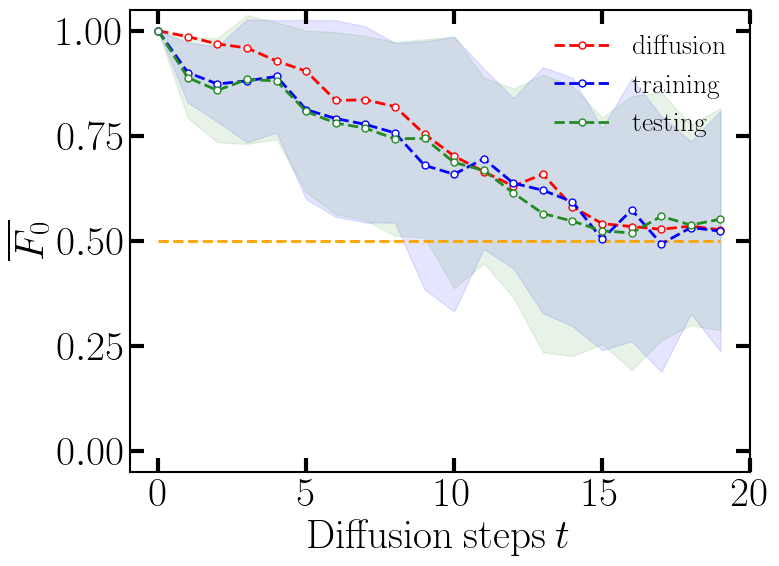

In [15]:
def compute_fidelity(Xout):
    '''
    rewriting the function to give _ALL_ of the fidelty computations before averaging over the batch (for the plot)
    '''
    arr = np.zeros((T,Ndata))
    for i in range(T):
        arr[i] = np.array([np.abs(np.inner(np.conjugate(Xout[0][kk][:]),Xout[i][kk][:]))**2 for kk in range(Ndata)]) 
    return arr
states_train = model.backDataGeneration(inputs_T_tr, params_tot, Ndata)[:, :, :2**n]
states_test = model.backDataGeneration(inputs_T_te, params_tot, Ndata)[:, :, :2**n]
states_diff = Xout

F0_train =compute_fidelity(states_train)
F0_test = compute_fidelity(states_test)
F0_diff = compute_fidelity(states_diff)

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(range(T), np.mean(F0_diff, axis=1), 'o--', markersize=5, mfc='white', lw=2, c='r', 
            zorder=5, label=r'$\rm diffusion$')
ax.plot(range(T), 0.5*np.ones(T), '--', lw=2, c='orange')

ax.plot(range(T), np.mean(F0_train, axis=1), 'o--', markersize=5, mfc='white', lw=2, c='b', 
            zorder=5, label=r'$\rm training$')
ax.fill_between(range(T), np.mean(F0_train, axis=1)-np.std(F0_train, axis=1), 
                    np.mean(F0_train, axis=1)+np.std(F0_train, axis=1), color='b', alpha=0.1)

ax.plot(range(T), np.mean(F0_test, axis=1), 'o--', markersize=5, mfc='white', lw=2, c='forestgreen', 
            zorder=5, label=r'$\rm testing$')
ax.fill_between(range(T), np.mean(F0_test, axis=1)-np.std(F0_test, axis=1), 
                    np.mean(F0_test, axis=1)+np.std(F0_test, axis=1), color='forestgreen', alpha=0.1)

ax.legend(fontsize=20, framealpha=0)
ax.set_ylim(-0.05, 1.05)
ax.set_xticks(np.arange(0, T+1, 5))
ax.set_xlabel(r'${\rm Diffusion\:steps}\:t$', fontsize=30)
ax.set_ylabel(r'$\overline{F_0}$', fontsize=30)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)

plt.show()
plt.close()

### Visulize the performance in MMD distance

In [16]:
# calculate MMD
X = torch.from_numpy(states_diff)
X_train = (states_train)
X_test = (states_test)
X0 = torch.from_numpy(cluster0Gen(1, 1000, 0.08, seed=16))

mmds = np.zeros((3, T))
for t in range(T):
    idx = np.random.choice(X.shape[1], size=100, replace=False)
    mmds[0, t] = naturalDistance(X0, X[t])
    mmds[1, t] = naturalDistance(X0, X_train[t])
    mmds[2, t] = naturalDistance(X0, X_test[t])


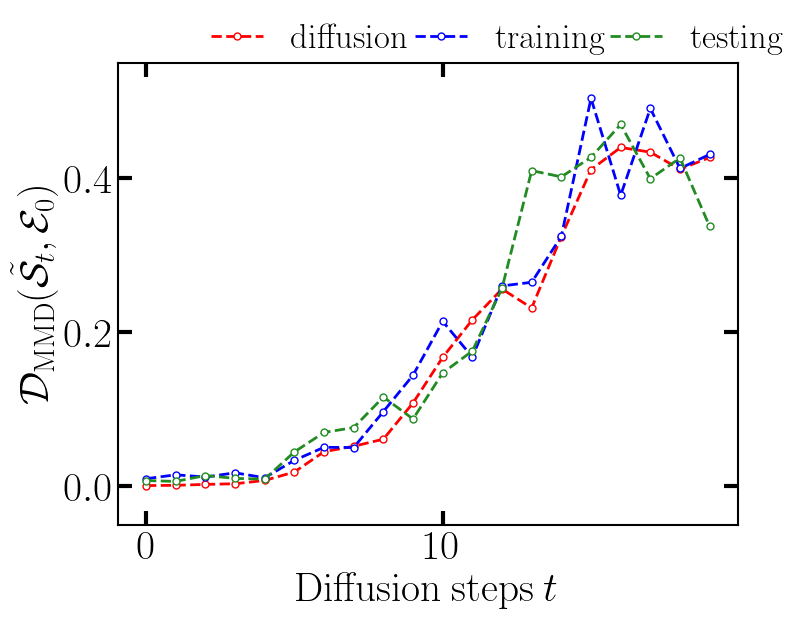

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(mmds[0], 'o--', markersize=5, mfc='white', lw=2, c='r', label=r'$\rm diffusion$')
ax.plot(mmds[1], 'o--', markersize=5, mfc='white', lw=2, c='b', label=r'$\rm training$')
ax.plot(mmds[2], 'o--', markersize=5, mfc='white', lw=2, c='forestgreen', label=r'$\rm testing$')

ax.legend(loc='lower left', bbox_to_anchor=(0.1, 0.95), fontsize=25, framealpha=0, labelspacing=0.4,
          ncol=3, columnspacing=0.2, handlelength=1.5)
ax.set_xlabel(r'${\rm Diffusion\:steps}\:t$', fontsize=30)
ax.set_ylabel(r'$\mathcal{D}_{\rm MMD}(\tilde{\mathcal{S}}_t, \mathcal{E}_0)$', fontsize=30)
ax.set_ylim(-0.05, 0.55)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)

### Plot the training history

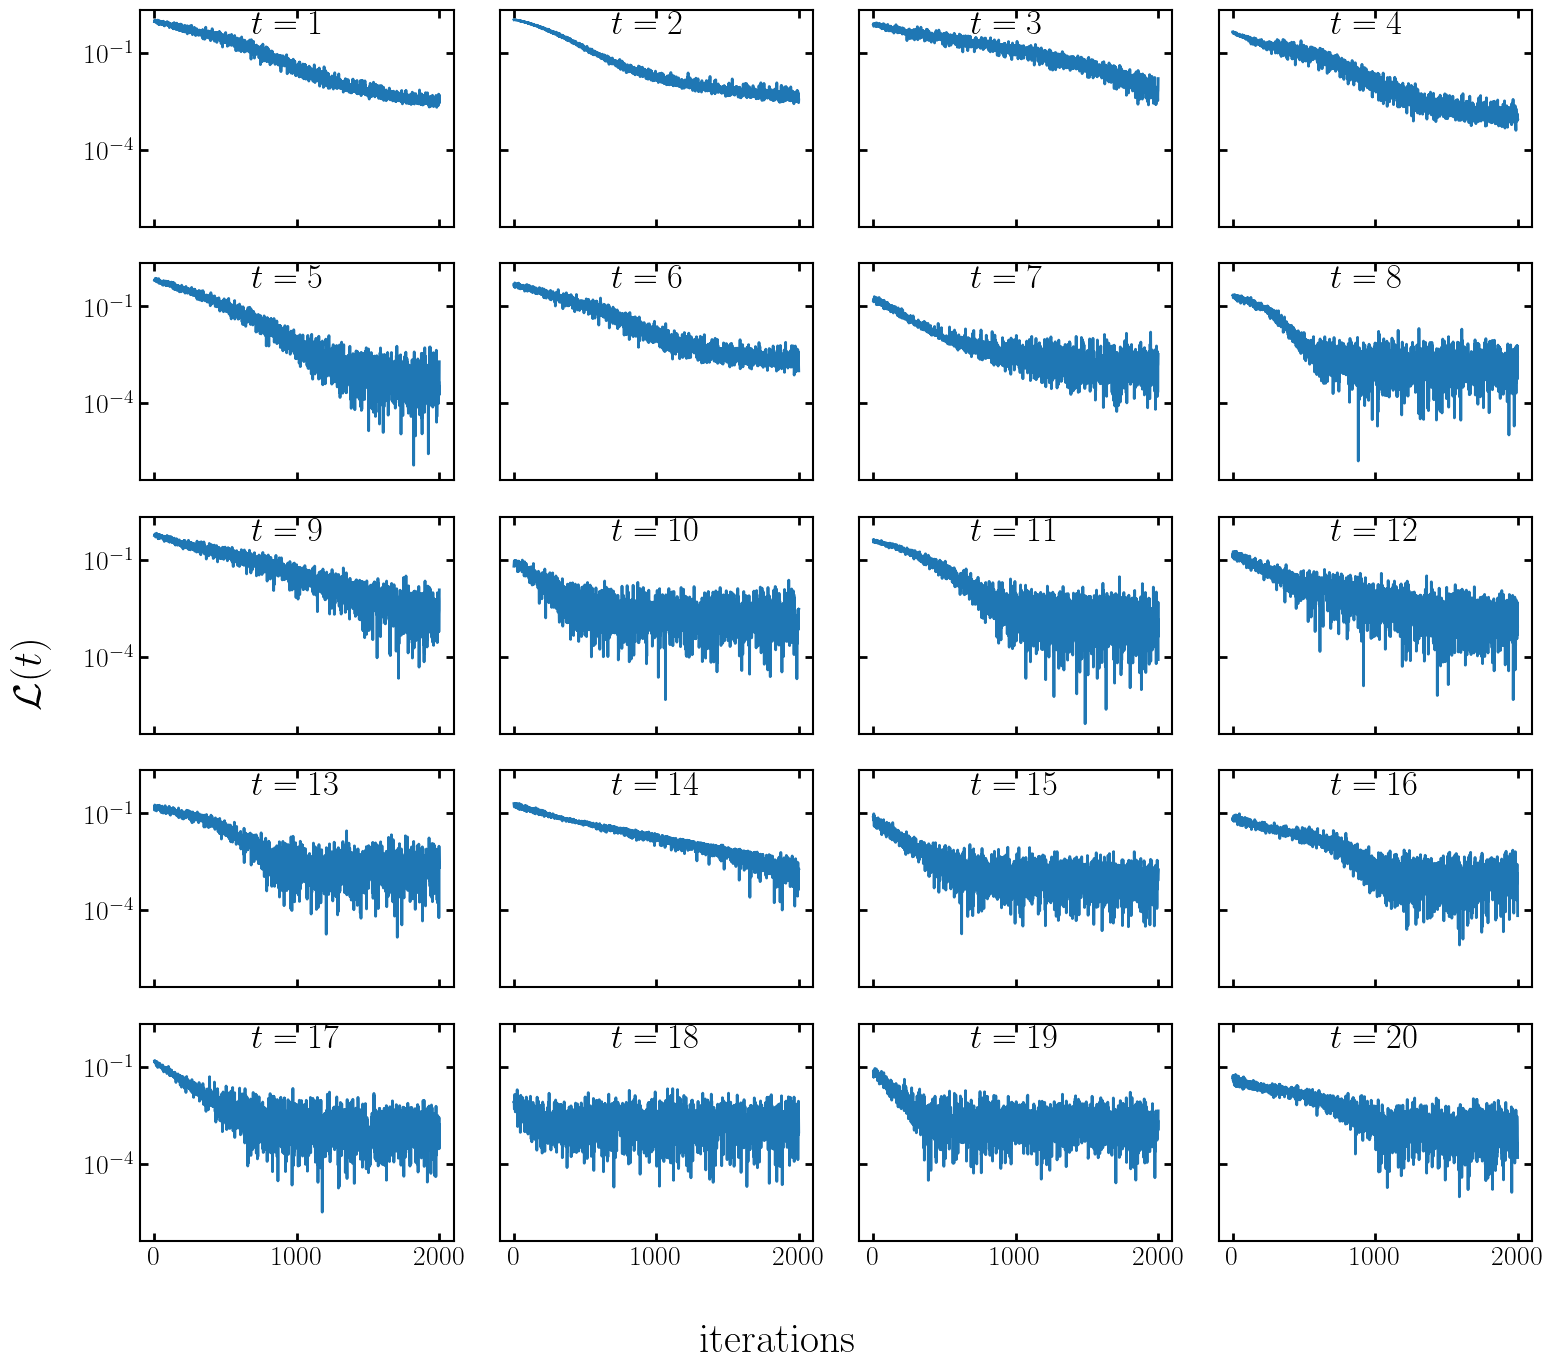

In [18]:
fig, axs = plt.subplots(5, 4, figsize=(16, 14), sharex=True, sharey=True)
for i in range(20):
    axs[i//4, i%4].plot(loss_tot[i], lw=2)
    axs[i//4, i%4].tick_params(direction='in', length=6, width=2, top='on', right='on', labelsize=20)
    axs[i//4, i%4].text(x=680, y=0.4, s=r'$t=%d$'%(i+1), fontsize=25)
    axs[i//4, i%4].set_yscale('log')
fig.supxlabel(r'$\rm iterations$', fontsize=30)
fig.supylabel(r'$\mathcal{L}(t)$', fontsize=30)
plt.tight_layout()
plt.show()
plt.close()

# Visualize the diffusion, training, and testing processes on the bloch sphere

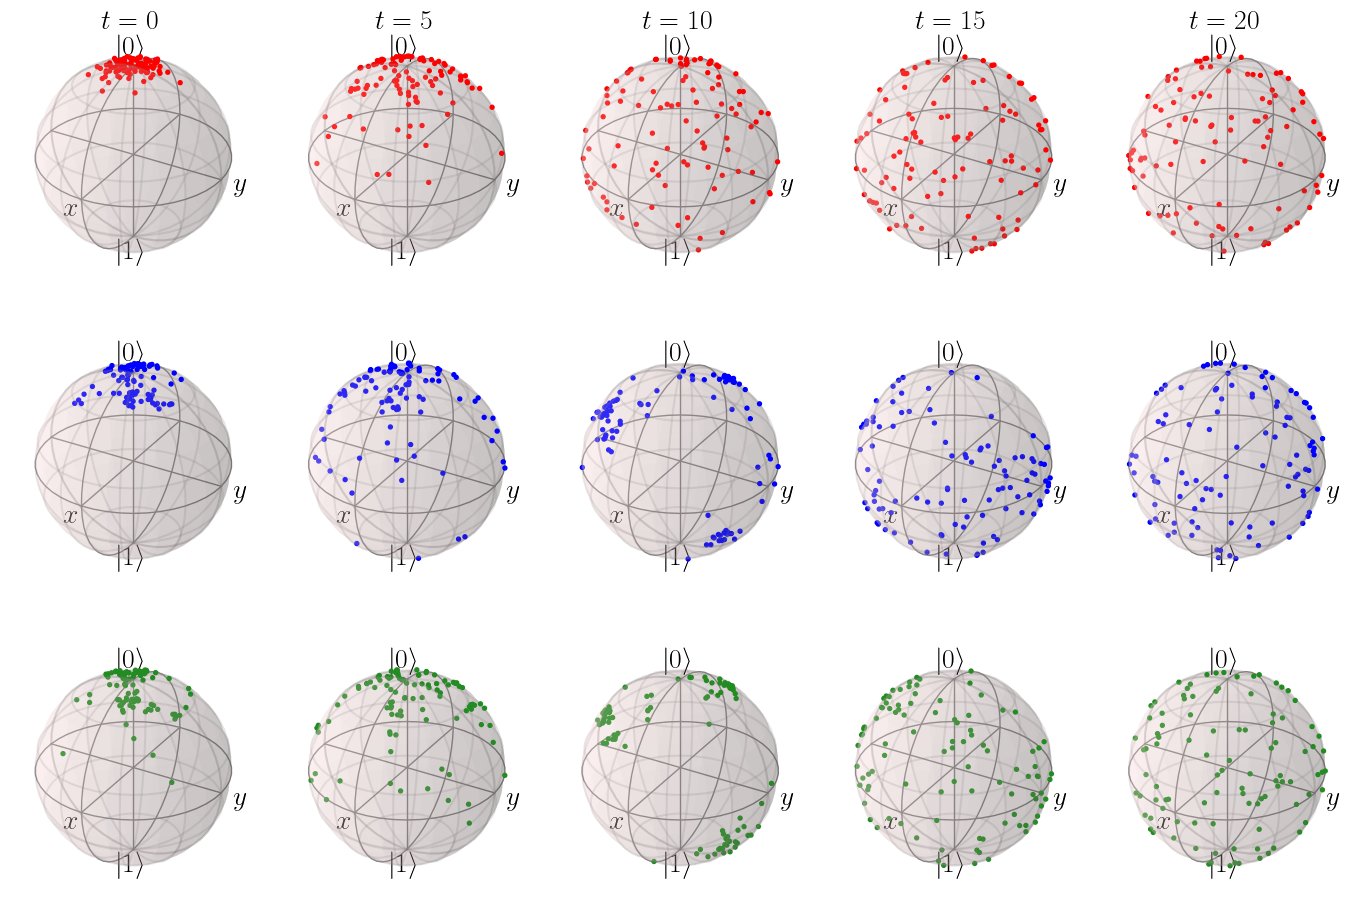

In [19]:
indices = np.random.choice(Ndata, Ndata, replace=False)
states_train = (model.backDataGeneration(inputs_T_tr, params_tot, Ndata)[:, :, :2**n]).detach().numpy()
states_test = (model.backDataGeneration(inputs_T_te, params_tot, Ndata)[:, :, :2**n]).detach().numpy()
states_diff = Xout

fig, axs = plt.subplots(3,5, figsize=(14,10), subplot_kw={'projection': '3d'})
cc = 0
for i in range(0, T+1, 5):
    xs0, ys0, zs0 = bloch_xyz(states_diff[i])
    xs1, ys1, zs1 = bloch_xyz(states_train[i])
    xs2, ys2, zs2 = bloch_xyz(states_test[i])
    b0 = Bloch(fig=fig, axes=axs[0,cc])
    b0.clear()
    b0.add_points([xs0, ys0, zs0])
    b0.point_color = ['r']*Ndata
    b0.point_style = 'm'
    b0.point_size = 8*np.ones(Ndata)
    b0.render()
    b1 = Bloch(fig=fig, axes=axs[1,cc])
    b1.clear()
    b1.add_points([xs1, ys1, zs1])
    b1.point_color = ['b']*Ndata
    b1.point_style = 'm'
    b1.point_size = 8*np.ones(Ndata)
    b1.render()
    b2 = Bloch(fig=fig, axes=axs[2,cc])
    b2.clear()
    b2.add_points([xs2, ys2, zs2])
    b2.point_color = ['forestgreen']*Ndata
    b2.point_style = 'm'
    b2.point_size = 8*np.ones(Ndata)
    b2.render()
    axs[0,cc].set_title(r'$t=%d$'%i, fontsize=20)
    cc += 1
plt.tight_layout()